Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
df_reg = pd.read_csv('problem1-reg_data.csv', sep=';')
df_auth = pd.read_csv('problem1-auth_data.csv', sep=';')

In [3]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Переведем значения uid в строковый тип, а время регистрации и авторизации в дату.

In [5]:
df_reg['uid'] = df_reg['uid'].astype('str')
df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s')
df_auth['uid'] = df_auth['uid'].astype('str')
df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s')

Посмотрим, как изменялось количество регистраций по годам.

In [6]:
reg_by_year = round(df_reg.reg_ts.dt.year.value_counts(normalize=True)*100, 2)

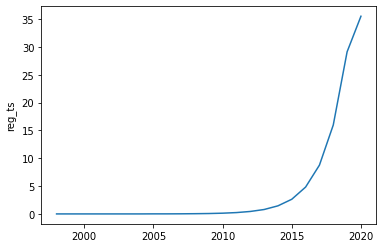

In [7]:
sns.lineplot(data=reg_by_year)

In [8]:
reg_by_year

2020    35.50
2019    29.11
2018    15.97
2017     8.76
2016     4.82
2015     2.63
2014     1.45
2013     0.79
2012     0.44
2011     0.24
2010     0.13
2009     0.07
2008     0.04
2007     0.02
2006     0.01
2005     0.01
2004     0.00
2003     0.00
2002     0.00
2001     0.00
2000     0.00
1999     0.00
1998     0.00
Name: reg_ts, dtype: float64

Для расчета Retention необходимо найти количество дней, прошедших с даты регистрации до каждой авторизации.

In [9]:
df_auth = df_auth.reset_index()

In [10]:
df_auth

,index,auth_ts,uid
0,0,1998-11-18 09:43:43,1
1,1,1999-07-22 22:38:09,2
2,2,1999-07-25 16:46:46,2
3,3,1999-07-31 03:50:15,2
4,4,1999-08-05 17:49:39,2
...,...,...,...
9601008,9601008,2020-09-23 15:13:54,1110618
9601009,9601009,2020-09-23 15:14:46,1110619
9601010,9601010,2020-09-23 15:15:39,1110620
9601011,9601011,2020-09-23 15:16:31,1110621


In [11]:
delta_df = df_auth.groupby(['uid', 'auth_ts'], as_index=False)\
                  .agg({'index': 'count'})\
                  .sort_values(['uid', 'auth_ts'])

In [12]:
delta_df['delta_days'] = delta_df.auth_ts.diff()
delta_df[delta_df.uid == '999999']

,uid,auth_ts,index,delta_days
9600996,999999,2020-07-21 19:57:15,1,0 days 00:00:58
9600997,999999,2020-07-26 01:40:06,1,4 days 05:42:51
9600998,999999,2020-07-31 21:13:20,1,5 days 19:33:14
9600999,999999,2020-08-03 07:07:16,1,2 days 09:53:56
9601000,999999,2020-08-06 16:11:38,1,3 days 09:04:22
9601001,999999,2020-08-08 09:59:02,1,1 days 17:47:24
9601002,999999,2020-08-13 15:51:02,1,5 days 05:52:00
9601003,999999,2020-08-15 08:24:47,1,1 days 16:33:45
9601004,999999,2020-08-17 19:09:08,1,2 days 10:44:21
9601005,999999,2020-08-19 17:39:16,1,1 days 22:30:08


Избавимся от значений в delta_days менее 5 минут (часть из них - это отрицательные значения, связанные с переходом к другому пользователю во время вычислений, другие - подозрительные значения, демонстрирующие частые входы в игру, что может быть, например, результатом деятельности ботов).

In [13]:
delta_df_clear = delta_df.query('delta_days > "0 days 00:05:00"')

Соединим полученный датафрейм с информацией о регистрации.

In [14]:
retention_df = delta_df_clear.merge(df_reg, how='left', on='uid')

In [15]:
retention_df.head()

,uid,auth_ts,index,delta_days,reg_ts
0,10,2001-09-20 02:07:54,1,1036 days 16:24:11,2001-09-20 02:07:54
1,1000,2009-01-21 16:56:02,1,2680 days 14:48:08,2009-01-21 16:56:02
2,10000,2012-11-21 22:58:47,1,1400 days 06:02:45,2012-11-21 22:58:47
3,100000,2016-09-20 02:33:46,1,1398 days 03:34:59,2016-09-20 02:33:46
4,1000000,2020-07-21 19:58:14,1,1400 days 17:24:28,2020-07-21 19:58:14


In [16]:
retention_df.drop(columns='index', axis=1, inplace=True)

In [17]:
retention_df.isna().sum()

uid           0
auth_ts       0
delta_days    0
reg_ts        0
dtype: int64

In [20]:
retention_df.head()

,uid,auth_ts,delta_days,reg_ts
0,10,2001-09-20 02:07:54,1036 days 16:24:11,2001-09-20 02:07:54
1,1000,2009-01-21 16:56:02,2680 days 14:48:08,2009-01-21 16:56:02
2,10000,2012-11-21 22:58:47,1400 days 06:02:45,2012-11-21 22:58:47
3,100000,2016-09-20 02:33:46,1398 days 03:34:59,2016-09-20 02:33:46
4,1000000,2020-07-21 19:58:14,1400 days 17:24:28,2020-07-21 19:58:14


Функция для расчета Retention rate

In [42]:
def retention_rate(retention_df, min_date, max_date, Nday):
    
    '''
    Извлекаем дату из колонок регистрации и авторизации, в дальнейшем подсчет retention ведем
    календарным способом, а не почасовым
    '''
    
    cohort_df = retention_df
    cohort_df['reg_date']=retention_df.reg_ts.dt.date
    cohort_df['auth_date']=retention_df.auth_ts.dt.date    

    
    cohort_df['days'] = (cohort_df['auth_date']-cohort_df['reg_date']).apply(lambda x: x.days)    
    
    
    ''' 
    Выбираем данные, относящиеся к анализируемому периоду, заданному в аргументах функции, 
    группируем по дате регистрации и количеству дней с регистрации,
    находим количество уникальных пользователей для каждой даты:
    '''

    cohort_df = cohort_df.loc[(cohort_df['reg_date'] >= pd.to_datetime(min_date))\
                              & (cohort_df['auth_date'] <= pd.to_datetime(max_date))\
                              & (cohort_df['days'] <= Nday)]\
                         .groupby(['reg_date','days'], as_index= False).agg({'uid':'nunique'})
   
    
    retention_table = cohort_df.pivot_table (index='reg_date', columns='days', values='uid')
    
    # Указываем количество пользователей, зарегистрировавшихся в каждый из анализируемых дней
    start_n_uid = retention_table.iloc[:, 0]
    
    #Рассчитываем retention для каждого дня
    retention = retention_table.divide(start_n_uid, axis=0).round(2)
    return retention
    


In [43]:
retention_rate(retention_df, '2020-05-12', '2020-05-23', 12)

days,0,1,2,3,4,5,6,7,8,9,10,11
reg_date,,,,,,,,,,,,
2020-05-12,1.0,0.12,0.48,0.43,0.53,0.63,0.60,0.54,0.49,0.54,0.60,0.56
2020-05-13,1.0,0.26,0.33,0.49,0.61,0.57,0.77,0.45,0.55,0.51,0.52,NaN
2020-05-14,1.0,0.30,0.43,0.60,0.55,0.68,0.72,0.67,0.46,0.50,NaN,NaN
2020-05-15,1.0,0.17,0.40,0.45,0.46,0.51,0.66,0.60,0.48,NaN,NaN,NaN
2020-05-16,1.0,0.17,0.39,0.52,0.41,0.65,0.62,0.49,NaN,NaN,NaN,NaN
2020-05-17,1.0,0.20,0.47,0.56,0.75,0.61,0.71,NaN,NaN,NaN,NaN,NaN
2020-05-18,1.0,0.23,0.50,0.51,0.74,0.68,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-19,1.0,0.22,0.40,0.54,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-20,1.0,0.23,0.49,0.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
